In [49]:
# ===== 0) CONFIG =====
GEOJSON_PATH =  "../data/ncc_neighborhood_full.geojson" 
CLIM_PATH    =  "../data/ncc_2t_timeseries_2010_2039.parquet"
LOCAL_TZ     = "Europe/London"       # used by model.local_hour()
N_STEPS      = 48                    # hours to simulate


In [50]:
# ===== 1) Imports & module hygiene =====
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [51]:
from household_energy.climate import ClimateField
from household_energy.model import EnergyModel

In [52]:

import os, sys, time, math, inspect, warnings
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import sys
from pathlib import Path



In [53]:
# ===== 2) Validate climate parquet (rectangular T×P) =====
ok_summary = ClimateField.validate_parquet(CLIM_PATH, verbose=True, return_summary=True)
assert ok_summary["rectangular"], "Climate parquet is not rectangular – fix upstream or filter timestamps."


[Climate parquet check]
  File: ../data/ncc_2t_timeseries_2010_2039.parquet
  Rows: 3,506,400 | T: 175,320 | P: 20 | T×P: 3,506,400
  Duplicates dropped: 9120
  Rows per timestamp → min/median/max: 20/20/20
  ✅ Rectangular grid (full T×P).


In [54]:
# ===== 3) Load geometry & ensure EPSG:4326 =====
gdf = gpd.read_file(GEOJSON_PATH)
if gdf.crs is None:
    raise ValueError("GeoJSON has no CRS. Set one (e.g., EPSG:4326) before running.")
if gdf.crs.to_string().upper() != "EPSG:4326":
    gdf = gdf.to_crs(4326)
    
# keep only needed cols (robust to missing optional cols)
keep = ["fid","geometry","property_type","sap_rating","energy_demand"]
for c in keep:
    if c not in gdf.columns: gdf[c] = np.nan
gdf = gdf[keep].copy()

In [55]:
# ===== 4) Choose a start time inside the parquet & show span =====
clim_meta = pd.read_parquet(CLIM_PATH, columns=["timestamp"]).sort_values("timestamp")
t0 = pd.to_datetime(clim_meta["timestamp"].iloc[0], utc=True)           # first hour
t1 = pd.to_datetime(clim_meta["timestamp"].iloc[-1], utc=True)          # last hour
print(f"Climate time span: {t0} → {t1}  (n={clim_meta['timestamp'].nunique()} hours)")


Climate time span: 2020-01-01 00:00:00+00:00 → 2039-12-31 23:00:00+00:00  (n=175320 hours)


In [67]:
# ===== 5) Build model + climate =====
t_build = time.perf_counter()
m = EnergyModel(
    gdf=gdf,
    climate_parquet=CLIM_PATH,
    climate_start=t0,        # align to first climate hour
    local_tz=LOCAL_TZ,
    level_scale=1.0,                  # keep raw level for now
    collect_agent_level=True,        # <-- critical for long 
)
t_build = time.perf_counter() - t_build
print(f"Model init time: {t_build:.2f}s  | households={len(m.household_agents)}, persons={len(m.person_agents)}")

# Small sanity: each house mapped to a climate index
assert m._clim_idx_per_house is not None and len(m._clim_idx_per_house) == len(m.household_agents)


/Users/abeltran/Documents/GitHub/spdt_abm/household_energy_abm/household_energy/model.py:57: RuntimeWarning: Mean of empty slice
  


Model init time: 20.62s  | households=91947, persons=183894


In [68]:
# ===== 6) Run a short simulation =====
t_run = time.perf_counter()
for _ in range(N_STEPS):
    m.step()
t_run = time.perf_counter() - t_run
print(f"Ran {N_STEPS} hours in {t_run:.2f}s")

Ran 48 hours in 20.54s


In [69]:
import pandas as pd
from household_energy.climate import ClimateField

cf = ClimateField(CLIM_PATH)
total_hours = len(cf.times)         # full parquet span
print("Total climate hours:", total_hours)


Total climate hours: 175320


In [70]:
# ===== 7) Pull outputs =====
agent_df = m.datacollector.get_agent_vars_dataframe()
model_df = m.datacollector.get_model_vars_dataframe()

display(model_df.tail(5))
display(agent_df.head(8))

,mid-terraced house,semi-detached house,small block of flats/dwelling converted in to flats,large block of flats,block of flats,end-terraced house,detached house,flat in mixed use building,high,medium,low,total_energy,cumulative_energy,ambient_mean_tempC,climate_hour_index
44,138945.669192,190708.384510,81491.571870,32391.050940,23988.083217,64671.785103,80445.144480,10670.992429,120087.24,91408.8,73209.6,623312.681741,2.735552e+07,10.336532,44
45,138514.420834,190127.593857,81239.081068,32285.732605,23898.913637,64450.895549,80237.872419,10636.722746,120087.24,91408.8,73209.6,621391.232715,2.797691e+07,10.545505,45
46,138039.331241,189511.629374,80907.775575,32141.654910,23790.889009,64223.268120,80000.025141,10595.331107,120087.24,91408.8,73209.6,619209.904477,2.859612e+07,10.782743,46
47,137621.710214,188975.257352,80590.450029,32005.798309,23691.953325,64022.731737,79829.571235,10551.887428,120087.24,91408.8,73209.6,617289.359628,2.921341e+07,10.991618,47
48,137737.366617,189152.104581,80633.671708,32021.804788,23713.359090,64087.021922,79893.111997,10556.219370,120087.24,91408.8,73209.6,617794.660074,2.983121e+07,10.936662,48


agent_type  energy  energy_consumption  ambient_tempC  \
Step AgentID                                                                   
0    osgb1000030010159  household     0.0                 0.0            NaN   
     osgb1000030010437  household     0.0                 0.0            NaN   
     osgb1000030012569  household     0.0                 0.0            NaN   
     osgb1000030012569  household     0.0                 0.0            NaN   
     osgb1000030012637  household     0.0                 0.0            NaN   
     osgb1000030012643  household     0.0                 0.0            NaN   
     osgb1000030010412  household     0.0                 0.0            NaN   
     osgb1000030012503  household     0.0                 0.0            NaN   

                        climate_heating_kWh  climate_cooling_kWh  
Step AgentID                                                      
0    osgb1000030010159                  0.0                  0.0  
     osgb1000030010437                  0.0                  0.0  
     osgb1000030012569                  0.0                  0.0  
     osgb1000030012569                  0.0                  0.0  
     osgb1000030012637                  0.0                  0.0  
     osgb1000030012643                  0.0                  0.0  
     osgb1000030010412                  0.0                  0.0  
     osgb1000030012503                  0.0                  0.0

Households at step 48: 91,947
       ambient_tempC  climate_heating_kWh  climate_cooling_kWh  \
count      91947.000            91947.000              91947.0   
mean          10.937                0.756                  0.0   
std            0.083                0.008                  0.0   
min           10.733                0.750                  0.0   
25%           10.902                0.752                  0.0   
50%           10.977                0.752                  0.0   
75%           10.977                0.760                  0.0   
max           10.997                0.777                  0.0   

       energy_consumption  
count           91947.000  
mean                6.719  
std                 2.440  
min                 2.511  
25%                 5.273  
50%                 6.201  
75%                 7.521  
max               156.661  


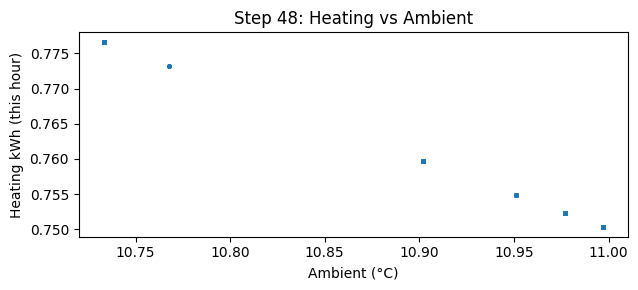

                                                    climate_heating_kWh  \
property_type                                                             
semi-detached house                                               0.758   
end-terraced house                                                0.758   
detached house                                                    0.757   
mid-terraced house                                                0.756   
block of flats                                                    0.755   
small block of flats/dwelling converted in to f...                0.754   
flat in mixed use building                                        0.753   
large block of flats                                              0.753   

                                                    climate_cooling_kWh  \
property_type                                                             
semi-detached house                                                 0.0   
end-terraced house      

/var/folders/rz/68rzz4790djdsk13ycd911f00000gr/T/ipykernel_83467/1185883615.py:42: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout(); plt.show()


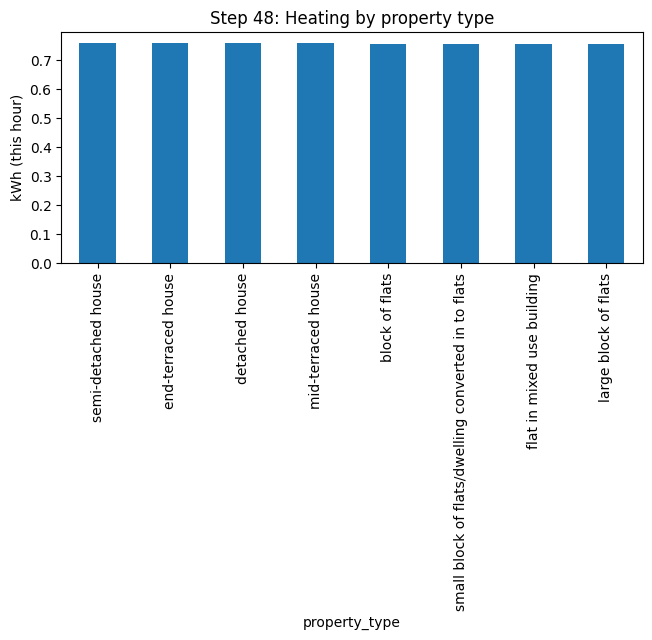

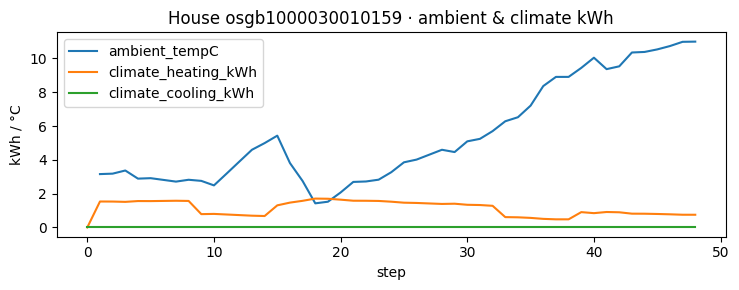

In [71]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 1) Narrow to last-step households (fast)
adf = m.datacollector.get_agent_vars_dataframe()
adf.index = adf.index.set_names(["step","AgentID"])
last_step = adf.index.get_level_values("step").max()

house_last = adf.loc[(last_step, slice(None)), :]
if "agent_type" in house_last.columns:
    house_last = house_last[house_last["agent_type"] == "household"]
else:
    # fallback if you remove agent_type later: households have ambient_tempC not NaN
    house_last = house_last[house_last["ambient_tempC"].notna()]

# basic sanity
print(f"Households at step {last_step}: {len(house_last):,}")
print(house_last[["ambient_tempC","climate_heating_kWh","climate_cooling_kWh","energy_consumption"]]
      .describe().round(3))

# 2) Quick plot: heating vs ambient (scatter, random 5k to keep it light)
sample = house_last.sample(min(5000, len(house_last)), random_state=0)
ax = sample.plot.scatter(x="ambient_tempC", y="climate_heating_kWh", s=5, alpha=0.4, figsize=(6.5,3))
ax.set_xlabel("Ambient (°C)"); ax.set_ylabel("Heating kWh (this hour)")
ax.set_title(f"Step {last_step}: Heating vs Ambient"); plt.tight_layout(); plt.show()

# 3) (Optional) add property_type for group-bys – pulled from the model
id_to_type = {h.unique_id: getattr(h, "property_type", "unknown") for h in m.household_agents}
house_last = house_last.assign(
    property_type=lambda df: df.index.get_level_values("AgentID").map(id_to_type)
)

# Group by property type (mean per house at this hour)
by_type = (house_last.groupby("property_type")[["climate_heating_kWh","climate_cooling_kWh","energy_consumption"]]
           .mean().sort_values("climate_heating_kWh", ascending=False))
print(by_type.head(10).round(3))

# Tiny bar chart of heating kWh by property type
ax = by_type["climate_heating_kWh"].plot(kind="bar", figsize=(7.5,3))
ax.set_ylabel("kWh (this hour)"); ax.set_title(f"Step {last_step}: Heating by property type")
plt.tight_layout(); plt.show()

# 4) One house over time (pick the first household id)
hid = house_last.index.get_level_values("AgentID")[0]
sub = adf.xs(hid, level="AgentID")
sub[["ambient_tempC","climate_heating_kWh","climate_cooling_kWh"]].plot(figsize=(7.5,3))
plt.title(f"House {hid} · ambient & climate kWh"); plt.ylabel("kWh / °C"); plt.tight_layout(); plt.show()


In [72]:
# ===== 8) Sanity checks on climate sampling =====
# A) ambient temps exist and are finite for most houses
amb_now = [getattr(h, "ambient_tempC", np.nan) for h in m.household_agents]
print("Current hour:", m.current_hour, "| sample ambient temps:", amb_now[:5])
assert np.isfinite(amb_now).mean() > 0.95, "Too many NaNs in ambient temps."

# B) households vs persons split; check climate fields present for households
#    Mesa agent parquet index is (step, AgentID). Find household rows via 'energy==0' heuristic.
agent_df = agent_df.reset_index()
house_rows = (agent_df["energy"] == 0) & (agent_df["energy_consumption"] > 0)
assert house_rows.any(), "No household rows detected – reporters may be misconfigured."

need_cols = {"ambient_tempC","climate_heating_kWh","climate_cooling_kWh"}
missing_cols = need_cols - set(agent_df.columns)
assert not missing_cols, f"Missing expected agent reporters: {missing_cols}"

Current hour: 48 | sample ambient temps: [10.99725341796875, 10.97674560546875, 10.97674560546875, 10.97674560546875, 10.97674560546875]


In [73]:
# ===== 9) Degree-hour consistency test (per-house) =====
# pick an arbitrary household id
hid = agent_df.loc[house_rows, "AgentID"].unique()[0]
sub = agent_df[agent_df["AgentID"] == hid].copy()

# compute expected heating degree-hours given model setpoint
setpoint = float(m.heating_setpoint_C)
sub["hd"] = (setpoint - sub["ambient_tempC"]).clip(lower=0)
# For rows where hd>0, heating_kWh should be close to hd * slope (within noise)
slope = float(m.heating_slope_kWh_per_deg)
mask = sub["hd"] > 0
if mask.sum() >= 5:
    ratio = (sub.loc[mask, "climate_heating_kWh"] / sub.loc[mask, "hd"]).median()
    print(f"Median heating_kWh/hd ratio: {ratio:.3f} (model slope={slope:.3f})")
    assert 0.8*slope <= ratio <= 1.2*slope, "Heating slope not reflected in kWh (±20% tolerance)."
else:
    print("Not enough heating hours in this window to validate slope (hd>0).")

# Cooling check is analogous (optional)
thr = float(m.cooling_threshold_C)
sub["cd"] = (sub["ambient_tempC"] - thr).clip(lower=0)
maskc = sub["cd"] > 0
if maskc.sum() >= 5:
    ratio_c = (sub.loc[maskc, "climate_cooling_kWh"] / sub.loc[maskc, "cd"]).median()
    print(f"Median cooling_kWh/cd ratio: {ratio_c:.3f} (model slope={m.cooling_slope_kWh_per_deg:.3f})")



Median heating_kWh/hd ratio: 0.100 (model slope=0.100)


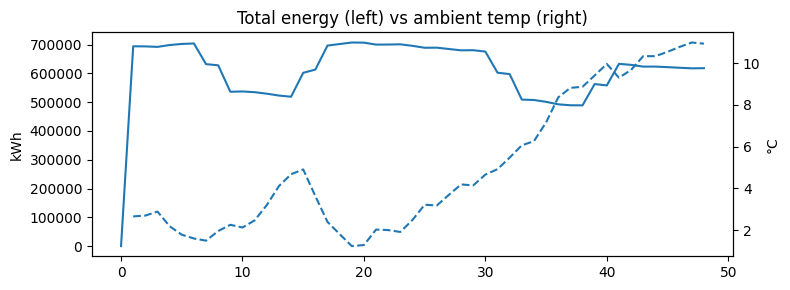

In [74]:
# ===== 10) Quick plots (robust) =====
import matplotlib.pyplot as plt

model_df = m.datacollector.get_model_vars_dataframe()

fig, ax1 = plt.subplots(figsize=(8,3))
model_df["total_energy"].plot(ax=ax1)
ax1.set_ylabel("kWh")
ax1.set_title("Total energy (left) vs ambient temp (right)")

ax2 = ax1.twinx()
model_df["ambient_mean_tempC"].plot(ax=ax2, linestyle="--")
ax2.set_ylabel("°C")

fig.tight_layout()
plt.show()


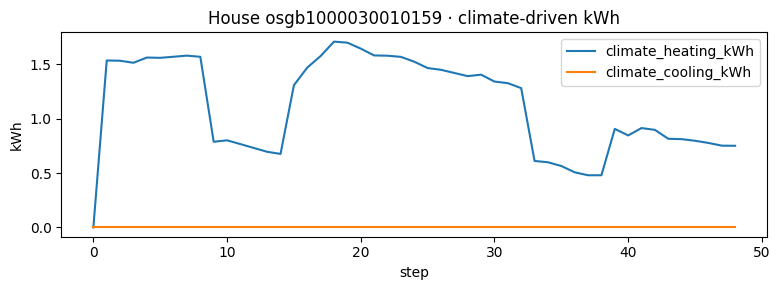

In [75]:
import pandas as pd

adf = m.datacollector.get_agent_vars_dataframe()
# make sure the index has names, then slice by AgentID without resetting
if isinstance(adf.index, pd.MultiIndex):
    adf.index = adf.index.set_names(["step","AgentID"])

# pick a house id (first one that has ambient temps)
hid = next(id_ for id_ in adf.index.get_level_values("AgentID").unique()
           if pd.notna(adf.xs(id_, level="AgentID")["ambient_tempC"]).any())

sub = adf.xs(hid, level="AgentID")

ax = sub[["climate_heating_kWh","climate_cooling_kWh"]].plot(figsize=(8,3))
ax.set_ylabel("kWh")
ax.set_title(f"House {hid} · climate-driven kWh")
ax.figure.tight_layout()
plt.show()


In [76]:
# ===== 11) Optional: verify local clock wiring =====
first_12 = [m.local_hour() - i % 24 for i in range(12)]
print("Local-hour drift check (should be mostly constant offsets):", first_12)

Local-hour drift check (should be mostly constant offsets): [0, -1, -2, -3, -4, -5, -6, -7, -8, -9, -10, -11]


In [77]:
# ===== 12) Performance summary =====
print(f"[Perf] init: {t_build:.2f}s | run({N_STEPS}h): {t_run:.2f}s | per-step: {t_run/max(1,N_STEPS):.4f}s")

[Perf] init: 20.62s | run(48h): 20.54s | per-step: 0.4279s


In [79]:
from pathlib import Path
import pandas as pd, time

def run_full_span(gdf, clim_path, outdir="results", flush_every_hours=24*14):
    outdir = Path(outdir); outdir.mkdir(exist_ok=True)
    from household_energy.climate import ClimateField
    from household_energy.model import EnergyModel

    cf = ClimateField(clim_path)
    start_utc = pd.to_datetime(cf.times[0], utc=True)
    T = len(cf.times)

    m = EnergyModel(gdf=gdf, climate_parquet=clim_path, climate_start=start_utc,
                    local_tz="Europe/London", collect_agent_level=False)

    t0 = time.perf_counter()
    for h in range(T):
        m.step()
        if (h+1) % (24*7) == 0:
            elapsed = time.perf_counter() - t0
            print(f"progress: {h+1:,}/{T:,} hours  |  elapsed: {elapsed:.1f}s")

        # optional: flush partial hourly parquet
        if (h+1) % flush_every_hours == 0:
            mdl = m.datacollector.get_model_vars_dataframe().copy()
            mdl["time_utc"] = start_utc + pd.to_timedelta(mdl.index, unit="h")
            mdl.set_index("time_utc").to_parquet(outdir / "model_hourly_partial.parquet")

    # final save
    mdl = m.datacollector.get_model_vars_dataframe().copy()
    mdl["time_utc"] = start_utc + pd.to_timedelta(mdl.index, unit="h")
    mdl = mdl.set_index("time_utc")
    mdl.to_parquet(outdir / "model_hourly.parquet")

    daily = pd.DataFrame({
        "total_energy_kWh":       mdl["total_energy"].resample("D").sum(),
        "ambient_mean_tempC_avg": mdl["ambient_mean_tempC"].resample("D").mean(),
    })
    daily.to_parquet(outdir / "model_daily.parquet")
    return mdl, daily


In [ ]:
# ===== FULL-SPAN RUNNER (daily outputs) =====
from pathlib import Path
import numpy as np
import pandas as pd
import time

# --- paths/config
OUTDIR = Path("results"); OUTDIR.mkdir(exist_ok=True)
HOURLY_OUT = OUTDIR / "model_hourly.parquet"   # optional – keep if you want hour-by-hour
DAILY_OUT  = OUTDIR / "model_daily.parquet"

# --- climate meta (get full span + start)
from household_energy.climate import ClimateField
cf = ClimateField(CLIM_PATH)
T_hours = len(cf.times)
start_utc = pd.to_datetime(cf.times[0], utc=True)
print(f"Climate span hours: {T_hours:,}  |  start: {start_utc}")

# --- build model (IMPORTANT: turn OFF agent-level collection)
from household_energy.model import EnergyModel
t0 = time.perf_counter()
m = EnergyModel(
    gdf=gdf,
    climate_parquet=CLIM_PATH,
    climate_start=start_utc,          # begin at first climate hour
    local_tz="Europe/London",
    level_scale=1.0,                  # keep raw level for now
    collect_agent_level=False,        # <-- critical for long runs
)
print(f"Init: {time.perf_counter()-t0:.2f}s | households={len(m.household_agents):,}, persons={len(m.person_agents):,}")

# --- run loop with lightweight progress
print_every_hours = 24 * 7  # print weekly progress
t_run = time.perf_counter()
for h in range(T_hours):
    m.step()
    if (h+1) % print_every_hours == 0:
        print(f" progressed {h+1:,}/{T_hours:,} hours")

print(f"Run done: {time.perf_counter()-t_run:.1f}s")

# --- pull model-level hourly frame (small enough to keep)
mdl = m.datacollector.get_model_vars_dataframe().copy()

# attach real UTC timestamps
mdl["time_utc"] = start_utc + pd.to_timedelta(mdl.index, unit="h")
mdl = mdl.set_index("time_utc")

# OPTIONAL: save hourly model-level results
mdl.to_parquet(HOURLY_OUT)
print(f"Saved hourly model-level → {HOURLY_OUT}")

# --- make daily aggregates for policy analysis
# sum energy over day; avg temperatures over day; keep by-type and by-wealth daily sums too
# detect which columns are property-type and wealth buckets
prop_cols   = [c for c in mdl.columns if c in m.energy_by_type.keys()]
wealth_cols = [c for c in ("high", "medium", "low") if c in mdl.columns]

daily = pd.DataFrame({
    "total_energy_kWh":       mdl["total_energy"].resample("D").sum(),
    "ambient_mean_tempC_avg": mdl["ambient_mean_tempC"].resample("D").mean(),
})

for c in prop_cols:
    daily[f"{c}_kWh"] = mdl[c].resample("D").sum()

for c in wealth_cols:
    daily[f"wealth_{c}_kWh"] = mdl[c].resample("D").sum()

daily.to_parquet(DAILY_OUT)  # e.g., results/model_daily.parquet
print(f"Saved daily aggregates → {DAILY_OUT}")

display(daily.head())
display(daily.tail())


Climate span hours: 175,320  |  start: 2020-01-01 00:00:00+00:00


/Users/abeltran/Documents/GitHub/spdt_abm/household_energy_abm/household_energy/model.py:57: RuntimeWarning: Mean of empty slice
  


Init: 15.00s | households=91,947, persons=183,894
 progressed 168/175,320 hours
 progressed 336/175,320 hours
 progressed 504/175,320 hours
 progressed 672/175,320 hours
 progressed 840/175,320 hours
 progressed 1,008/175,320 hours
 progressed 1,176/175,320 hours
 progressed 1,344/175,320 hours
 progressed 1,512/175,320 hours
 progressed 1,680/175,320 hours
 progressed 1,848/175,320 hours
 progressed 2,016/175,320 hours
 progressed 2,184/175,320 hours
 progressed 2,352/175,320 hours
 progressed 2,520/175,320 hours
 progressed 2,688/175,320 hours
 progressed 2,856/175,320 hours
 progressed 3,024/175,320 hours
 progressed 3,192/175,320 hours
 progressed 3,360/175,320 hours
 progressed 3,528/175,320 hours
 progressed 3,696/175,320 hours
 progressed 3,864/175,320 hours
 progressed 4,032/175,320 hours
 progressed 4,200/175,320 hours
 progressed 4,368/175,320 hours
 progressed 4,536/175,320 hours
 progressed 4,704/175,320 hours
 progressed 4,872/175,320 hours
 progressed 5,040/175,320 hours


ModuleNotFoundError: No module named 'modules.agent'

In [82]:
prop_cols   = [c for c in mdl.columns if c in m.energy_by_type.keys()]
wealth_cols = [c for c in ("high", "medium", "low") if c in mdl.columns]

daily = pd.DataFrame({
    "total_energy_kWh":       mdl["total_energy"].resample("D").sum(),
    "ambient_mean_tempC_avg": mdl["ambient_mean_tempC"].resample("D").mean(),
})

for c in prop_cols:
    daily[f"{c}_kWh"] = mdl[c].resample("D").sum()

for c in wealth_cols:
    daily[f"wealth_{c}_kWh"] = mdl[c].resample("D").sum()

daily.to_parquet(DAILY_OUT)  # e.g., results/model_daily.parquet
print(f"Saved daily aggregates → {DAILY_OUT}")

Saved daily aggregates → results/model_daily.parquet


In [83]:
display(daily.head())
display(daily.tail())

,total_energy_kWh,ambient_mean_tempC_avg,mid-terraced house_kWh,semi-detached house_kWh,small block of flats/dwelling converted in to flats_kWh,large block of flats_kWh,block of flats_kWh,end-terraced house_kWh,detached house_kWh,flat in mixed use building_kWh,wealth_high_kWh,wealth_medium_kWh,wealth_low_kWh
time_utc,,,,,,,,,,,,,
2020-01-01 00:00:00+00:00,1.475114e+07,2.497284,3.282958e+06,4.502908e+06,1.934412e+06,772822.317280,571507.663504,1.531518e+06,1.901097e+06,253921.932168,2.276958e+06,1796965.1,1.449598e+06
2020-01-02 00:00:00+00:00,1.447068e+07,7.205311,3.224623e+06,4.437039e+06,1.876175e+06,745055.116658,550094.188030,1.501232e+06,1.889751e+06,246711.167228,2.396384e+06,1889343.2,1.522439e+06
2020-01-03 00:00:00+00:00,1.479579e+07,5.513101,3.295218e+06,4.528819e+06,1.928064e+06,767336.732789,566663.240021,1.535021e+06,1.921269e+06,253397.256426,2.396384e+06,1889343.2,1.522439e+06
2020-01-04 00:00:00+00:00,1.465030e+07,6.338914,3.263118e+06,4.486404e+06,1.907246e+06,758423.241122,559590.646523,1.519248e+06,1.905479e+06,250787.993322,2.396384e+06,1889343.2,1.522439e+06
2020-01-05 00:00:00+00:00,1.444354e+07,7.342657,3.217440e+06,4.425855e+06,1.877628e+06,745867.741163,549612.266814,1.496560e+06,1.883675e+06,246906.432300,2.396384e+06,1889343.2,1.522439e+06


,total_energy_kWh,ambient_mean_tempC_avg,mid-terraced house_kWh,semi-detached house_kWh,small block of flats/dwelling converted in to flats_kWh,large block of flats_kWh,block of flats_kWh,end-terraced house_kWh,detached house_kWh,flat in mixed use building_kWh,wealth_high_kWh,wealth_medium_kWh,wealth_low_kWh
time_utc,,,,,,,,,,,,,
2039-12-28 00:00:00+00:00,1.608824e+07,-0.605118,3.576391e+06,4.892338e+06,2.132801e+06,855532.070469,631907.515661,1.669921e+06,2.049176e+06,280170.501150,2.396384e+06,1889343.2,1.522439e+06
2039-12-29 00:00:00+00:00,1.633082e+07,-1.716678,3.629665e+06,4.960650e+06,2.169492e+06,871549.414836,643943.552065,1.695446e+06,2.075270e+06,284807.092675,2.396384e+06,1889343.2,1.522439e+06
2039-12-30 00:00:00+00:00,1.626694e+07,-1.466422,3.615945e+06,4.942645e+06,2.158830e+06,867093.324116,640756.880512,1.688688e+06,2.069750e+06,283232.596807,2.396384e+06,1889343.2,1.522439e+06
2039-12-31 00:00:00+00:00,1.607974e+07,-0.571125,3.574705e+06,4.890265e+06,2.130300e+06,854615.091157,631449.471412,1.668956e+06,2.049878e+06,279571.017074,2.396384e+06,1889343.2,1.522439e+06
2040-01-01 00:00:00+00:00,7.185155e+05,-0.024147,1.596625e+05,2.177042e+05,9.624348e+04,38772.527323,28705.159624,7.472534e+04,9.008954e+04,12612.665986,1.194258e+05,92378.1,7.284120e+04


,desnz_total_kWh,desnz_meters,desnz_mean_kWh,model_total_kWh,model_homes,model_mean_kWh,homes_to_meters_ratio,mean_kWh_ratio,level_scale_needed
2020,"415,382,035",129,"3,216","5,155,911,991","91,947","56,075",711.929,17.435,0.081
2021,"397,302,011",131,"3,041","5,131,575,098","91,947","55,810",703.825,18.351,0.077
2022,"374,325,163",132,"2,845","5,197,918,404","91,947","56,532",698.733,19.873,0.072
2023,"381,010,659",132,"2,881","5,183,409,201","91,947","56,374",695.209,19.569,0.074


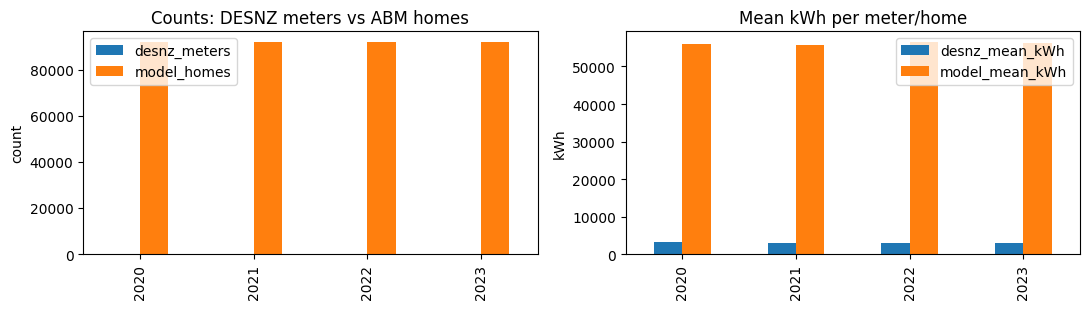


Overall ratios (2020–2023 sums):
homes_to_meters_ratio   702.368
mean_kWh_ratio           18.759
level_scale_needed        0.076


In [85]:
# === Newcastle: DESNZ meters & mean vs ABM households & mean (2020–2023) ===
from pathlib import Path
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ---- config ----
YEARS = [2020, 2021, 2022, 2023]
LA    = "Newcastle upon Tyne"
XLSX_CANDIDATES = [
    Path("../data/Subnational_electricity_consumption_statistics_2005-2023.xlsx"),
    Path("/mnt/data/Subnational_electricity_consumption_statistics_2005-2023.xlsx"),
]
XLSX = next((p for p in XLSX_CANDIDATES if p.exists()), None)
assert XLSX is not None, "DESNZ workbook not found. Update the XLSX path."

# ---- helpers ----
def _header_row_for_sheet(xl, sheet: str) -> int:
    raw = xl.parse(sheet, header=None, nrows=40)
    for r in range(len(raw)):
        if any(isinstance(v, str) and v.strip().lower() == "local authority" for v in raw.iloc[r].tolist()):
            return r
    raise ValueError(f"Couldn't find 'Local authority' header in sheet '{sheet}'")

def _norm_cols(cols):
    return [re.sub(r"\s+", " ", str(c)).strip() for c in cols]

def _find_col(cols, *need):
    """Find first column whose name contains all tokens in `need` (case-insensitive)."""
    lc = [c.lower() for c in cols]
    for c, cl in zip(cols, lc):
        if all(tok.lower() in cl for tok in need):
            return c
    return None

def desnz_la_metrics(xlsx_path: str | Path, la: str, years: list[int]) -> pd.DataFrame:
    """Return DataFrame with columns: desnz_total_kWh, desnz_meters, desnz_mean_kWh."""
    xl = pd.ExcelFile(xlsx_path)
    rows = []
    for y in years:
        sheet = str(y)
        hdr = _header_row_for_sheet(xl, sheet)
        df  = xl.parse(sheet, header=hdr)
        df.columns = _norm_cols(df.columns)

        la_row = df[df["Local authority"].astype(str).str.lower().str.contains(la.lower())]
        if la_row.empty:
            raise ValueError(f"LA '{la}' not found in sheet {sheet}")

        # columns (robust to wording)
        col_tot_gwh = _find_col(df.columns, "total consumption", "all domestic", "gwh")
        col_meters  = _find_col(df.columns, "number of meters", "all domestic")
        col_mean    = _find_col(df.columns, "mean consumption", "all domestic", "kwh")

        total_kwh = float(pd.to_numeric(la_row.iloc[0][col_tot_gwh], errors="coerce")) * 1_000_000.0 if col_tot_gwh else np.nan
        meters    = float(pd.to_numeric(la_row.iloc[0][col_meters ], errors="coerce")) if col_meters else np.nan

        if col_mean:
            mean_kwh = float(pd.to_numeric(la_row.iloc[0][col_mean], errors="coerce"))
        else:
            mean_kwh = (total_kwh / meters) if (np.isfinite(total_kwh) and np.isfinite(meters) and meters > 0) else np.nan

        rows.append({"year": y, "desnz_total_kWh": total_kwh, "desnz_meters": meters, "desnz_mean_kWh": mean_kwh})
    return pd.DataFrame(rows).set_index("year").sort_index()

def model_yearly_totals(m, years: list[int]) -> tuple[pd.Series, int]:
    """Return (model_total_kWh by year, n_households)."""
    mdl = m.datacollector.get_model_vars_dataframe().copy()
    start_utc = pd.to_datetime(m.climate.times[m._t0], utc=True)
    mdl["time_utc"] = start_utc + pd.to_timedelta(mdl.index, unit="h")
    mdl = mdl.set_index("time_utc")
    totals = mdl["total_energy"].groupby(mdl.index.year).sum().reindex(years)
    n_households = len(m.household_agents)
    return totals, n_households

# ---- compute ----
desnz = desnz_la_metrics(XLSX, LA, YEARS)
model_totals, n_homes = model_yearly_totals(m, YEARS)

cmp = pd.DataFrame({
    "desnz_total_kWh": desnz["desnz_total_kWh"],
    "desnz_meters":    desnz["desnz_meters"],
    "desnz_mean_kWh":  desnz["desnz_mean_kWh"],
    "model_total_kWh": model_totals,
})
cmp["model_homes"]     = n_homes
cmp["model_mean_kWh"]  = cmp["model_total_kWh"] / cmp["model_homes"]

# Ratios / diagnostics
cmp["homes_to_meters_ratio"] = cmp["model_homes"] / cmp["desnz_meters"]
cmp["mean_kWh_ratio"]        = cmp["model_mean_kWh"] / cmp["desnz_mean_kWh"]
cmp["level_scale_needed"]    = cmp["desnz_total_kWh"] / cmp["model_total_kWh"]

display(
    cmp.style.format({
        "desnz_total_kWh": "{:,.0f}",
        "desnz_meters": "{:,.0f}",
        "desnz_mean_kWh": "{:,.0f}",
        "model_total_kWh": "{:,.0f}",
        "model_homes": "{:,.0f}",
        "model_mean_kWh": "{:,.0f}",
        "homes_to_meters_ratio": "{:.3f}",
        "mean_kWh_ratio": "{:.3f}",
        "level_scale_needed": "{:.3f}",
    }).set_caption(f"{LA}: DESNZ vs ABM (2020–2023)")
)

# ---- quick visuals ----
fig, axes = plt.subplots(1, 2, figsize=(11, 3.2))

cmp[["desnz_meters"]].assign(model_homes=cmp["model_homes"]).plot(kind="bar", ax=axes[0])
axes[0].set_title("Counts: DESNZ meters vs ABM homes"); axes[0].set_ylabel("count")

cmp[["desnz_mean_kWh","model_mean_kWh"]].plot(kind="bar", ax=axes[1])
axes[1].set_title("Mean kWh per meter/home"); axes[1].set_ylabel("kWh")

plt.tight_layout(); plt.show()

print("\nOverall ratios (2020–2023 sums):")
overall = pd.Series({
    "homes_to_meters_ratio": (cmp["model_homes"].sum() / cmp["desnz_meters"].sum()),
    "mean_kWh_ratio":        ((cmp["model_mean_kWh"].mean()) / (cmp["desnz_mean_kWh"].mean())),
    "level_scale_needed":    (cmp["desnz_total_kWh"].sum() / cmp["model_total_kWh"].sum()),
})
print(overall.to_string(float_format=lambda x: f"{x:.3f}"))


In [91]:
# ==== Compare gdf['energy_demand'] to DESNZ 2023 (two interpretations) ====
from pathlib import Path
import re
import numpy as np
import pandas as pd

LA  = "Newcastle upon Tyne"
YEAR = 2023

# locate the workbook
XLSX_CANDIDATES = [
    Path("../data/Subnational_electricity_consumption_statistics_2005-2023.xlsx"),
    Path("/mnt/data/Subnational_electricity_consumption_statistics_2005-2023.xlsx"),
]
XLSX = next((p for p in XLSX_CANDIDATES if p.exists()), None)
assert XLSX is not None, "DESNZ workbook not found—update the path."

# --- DESNZ loader (robust to header wording; meters may be 'thousands') ---
def _header_row_for_sheet(xl, sheet: str) -> int:
    raw = xl.parse(sheet, header=None, nrows=50)
    for r in range(len(raw)):
        if any(isinstance(v,str) and v.strip().lower()=="local authority" for v in raw.iloc[r].tolist()):
            return r
    raise ValueError(f"Header row not found in sheet '{sheet}'")

def _norm_cols(cols): return [re.sub(r"\s+"," ",str(c)).strip() for c in cols]
def _find_col(cols, *need):
    lc = [c.lower() for c in cols]
    for c, cl in zip(cols, lc):
        if all(tok.lower() in cl for tok in need): return c
    return None

def desnz_metrics_for_year(xlsx_path: str | Path, la: str, year: int) -> dict:
    xl = pd.ExcelFile(xlsx_path); sheet = str(year)
    hdr = _header_row_for_sheet(xl, sheet)
    df  = xl.parse(sheet, header=hdr); df.columns = _norm_cols(df.columns)
    row = df[df["Local authority"].astype(str).str.lower().str.contains(la.lower())]
    if row.empty: raise ValueError(f"LA '{la}' not found in {sheet}")

    col_tot_gwh = _find_col(df.columns, "total consumption", "all domestic", "gwh")
    col_meters  = _find_col(df.columns, "number of meters", "all domestic")
    col_mean    = _find_col(df.columns, "mean consumption", "all domestic", "kwh")

    total_kwh = float(pd.to_numeric(row.iloc[0][col_tot_gwh], errors="coerce")) * 1_000_000.0
    meters_raw = float(pd.to_numeric(row.iloc[0][col_meters], errors="coerce"))
    meters_unit = "thousands" if re.search(r"thousand|000|\(000s\)|\(thousands\)", col_meters, re.I) else "count"
    meters = meters_raw * (1000.0 if meters_unit == "thousands" else 1.0)

    if col_mean:
        mean_kwh = float(pd.to_numeric(row.iloc[0][col_mean], errors="coerce"))
    else:
        mean_kwh = total_kwh / meters if meters > 0 else np.nan

    return {"year": year, "desnz_total_kWh": total_kwh, "desnz_meters": meters, "desnz_mean_kWh": mean_kwh,
            "_meter_col": col_meters, "_meters_unit": meters_unit}

D = desnz_metrics_for_year(XLSX, LA, YEAR)

# --- ABM side from gdf ---
assert "energy_demand" in gdf.columns, "gdf must have 'energy_demand' (kWh/year)."
assert "property_type" in gdf.columns, "gdf must have 'PROPERTY_property_typeTYPE' (dwellings per polygon)."

E = pd.to_numeric(gdf["energy_demand"], errors="coerce")
N = pd.to_numeric(gdf["property_type"], errors="coerce").fillna(1).clip(lower=1).round()  # dwellings per polygon (>=1, int-like)

mask = E.notna() & N.notna()
E = E[mask]; N = N[mask]

abm_polygons   = int(len(E))
abm_eff_homes  = int(N.sum())

# A) INTERPRETATION: energy_demand is BUILDING TOTAL (kWh/yr per polygon)
A_total_kWh = float(E.sum())
A_mean_per_polygon = float(E.mean())
A_mean_per_dwelling = float(A_total_kWh / abm_eff_homes)  # distribute building total over its dwellings

# B) INTERPRETATION: energy_demand is PER DWELLING (kWh/yr per dwelling)
B_total_kWh = float((E * N).sum())
B_mean_per_dwelling = float(B_total_kWh / abm_eff_homes)  # weighted mean of E by N
B_mean_per_polygon  = float((E * N).sum() / abm_polygons) # average polygon's total if per-dwelling

# --- Build comparison table vs DESNZ 2023 ---
rows = [
    ["DESNZ 2023",      D["desnz_total_kWh"], D["desnz_meters"], D["desnz_mean_kWh"], np.nan, np.nan],
    ["ABM (A: building total)", A_total_kWh,   abm_eff_homes,     A_mean_per_dwelling, abm_polygons, A_mean_per_polygon],
    ["ABM (B: per dwelling)",   B_total_kWh,   abm_eff_homes,     B_mean_per_dwelling, abm_polygons, B_mean_per_polygon],
]
out = pd.DataFrame(rows, columns=[
    "source",
    "total_kWh",
    "homes_or_meters",
    "mean_kWh_per_home",
    "polygons",
    "mean_kWh_per_polygon"
])

# ratios to DESNZ for the two ABM interpretations
def pct_diff(model, ref): 
    return np.nan if not np.isfinite(model) or not np.isfinite(ref) or ref==0 else 100.0*(model-ref)/ref

ratio_rows = []
for label, tot, mean in [
    ("ABM A vs DESNZ", A_total_kWh, A_mean_per_dwelling),
    ("ABM B vs DESNZ", B_total_kWh, B_mean_per_dwelling),
]:
    ratio_rows.append({
        "comparison": label,
        "total_ratio (model/ref)": tot / D["desnz_total_kWh"],
        "total_pct_diff": pct_diff(tot, D["desnz_total_kWh"]),
        "mean_ratio (model/ref)": mean / D["desnz_mean_kWh"],
        "mean_pct_diff": pct_diff(mean, D["desnz_mean_kWh"]),
        "homes_to_meters_ratio": abm_eff_homes / D["desnz_meters"],
    })
ratios = pd.DataFrame(ratio_rows)

print(f"DESNZ meters column: {D['_meter_col']}  (interpreted units: {D['_meters_unit']})")
display(out.style.format({
    "total_kWh": "{:,.0f}",
    "homes_or_meters": "{:,.0f}",
    "mean_kWh_per_home": "{:,.0f}",
    "polygons": "{:,.0f}",
    "mean_kWh_per_polygon": "{:,.0f}",
}))
display(ratios.style.format({
    "total_ratio (model/ref)": "{:.3f}",
    "total_pct_diff": "{:+.1f}%",
    "mean_ratio (model/ref)": "{:.3f}",
    "mean_pct_diff": "{:+.1f}%",
    "homes_to_meters_ratio": "{:.3f}",
}))


DESNZ meters column: Number of meters (thousands): All Domestic  (interpreted units: thousands)


,source,total_kWh,homes_or_meters,mean_kWh_per_home,polygons,mean_kWh_per_polygon
0,DESNZ 2023,"381,010,659","132,258","2,881",nan,nan
1,ABM (A: building total),"2,027,719,496","91,947","22,053","91,947","22,053"
2,ABM (B: per dwelling),"2,027,719,496","91,947","22,053","91,947","22,053"


,comparison,total_ratio (model/ref),total_pct_diff,mean_ratio (model/ref),mean_pct_diff,homes_to_meters_ratio
0,ABM A vs DESNZ,5.322,+432.2%,7.655,+665.5%,0.695
1,ABM B vs DESNZ,5.322,+432.2%,7.655,+665.5%,0.695


In [89]:
gdf

,fid,geometry,property_type,sap_rating,energy_demand
0,osgb1000030010159,"POLYGON ((-1.65248 54.98531, -1.65221 54.98533...",Mid-terraced house,48.0,37677.0
1,osgb1000030010437,"POLYGON ((-1.65218 54.98675, -1.65204 54.98677...",Semi-detached house,69.0,21840.0
2,osgb1000030012569,"POLYGON ((-1.65354 54.99075, -1.65355 54.99079...",Small block of flats/dwelling converted in to ...,65.0,15930.0
3,osgb1000030012569,"POLYGON ((-1.65354 54.99075, -1.65355 54.99079...",Small block of flats/dwelling converted in to ...,69.0,18612.0
4,osgb1000030012637,"POLYGON ((-1.65252 54.98843, -1.65251 54.98843...",Semi-detached house,69.0,21945.0
...,...,...,...,...,...
91942,osgb1000030080692,"POLYGON ((-1.61898 54.97526, -1.61903 54.97531...",Large block of flats,81.0,19241.0
91943,osgb1000030080692,"POLYGON ((-1.61898 54.97526, -1.61903 54.97531...",Large block of flats,81.0,19100.0
91944,osgb1000030080692,"POLYGON ((-1.61898 54.97526, -1.61903 54.97531...",Large block of flats,81.0,19241.0
91945,osgb1000030080692,"POLYGON ((-1.61898 54.97526, -1.61903 54.97531...",Large block of flats,81.0,19241.0


In [92]:
import pandas as pd
import numpy as np

# --- basic: treat `energy_demand` as kWh/year per polygon ---
E = pd.to_numeric(gdf["energy_demand"], errors="coerce").dropna()

avg_kwh_per_polygon = float(E.mean())
total_kwh_per_year  = float(E.sum())

print(f"Average energy_demand (kWh/yr per polygon): {avg_kwh_per_polygon:,.0f}")
print(f"Total energy_demand for the year (kWh):     {total_kwh_per_year:,.0f}")

Average energy_demand (kWh/yr per polygon): 22,053
Total energy_demand for the year (kWh):     2,027,719,496
